## Problem Set 01
### AST 8110, Fall 2022
#### Tyler Barna

In [1]:
import time
bigstart = time.time()
## Importing packages (some of these may not be useful)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as stats
#import numba

import sys
import os
import astropy
import astropy.units as u
import astropy.constants as const
import astropy.coordinates as coord
import random
from tqdm import tqdm
#from numba import jit
from scipy.stats import binned_statistic as binstat

## Set Seed
random.seed(8110)

## debug mode for fast testing
debug = False
filt = 10 ## factor to reduce the size of the data set by


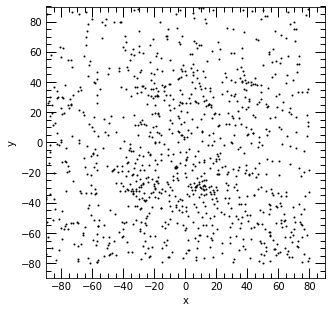

In [2]:
## read in data
data = np.loadtxt('pset1data.txt')
if debug:
    data = data[::filt]

## plot data
def plot_data(dat=data):
    fig, ax = plt.figure(figsize=(5,5)), plt.gca()
    ax.minorticks_on()
    ax.tick_params(axis='both', which='major',direction='in',top=True,right=True,length=10,width=1)
    ax.tick_params(axis='both', which='minor',direction='in',top=True,right=True, length=5,width=1)
    
    ax.plot(dat[:,0],dat[:,1],'.',markersize=2,color='black');
    plt.xlim(-90,90);
    plt.ylim(-90,90);
    plt.xlabel('x');
    plt.ylabel('y');
    return fig, ax
    
plot_data(dat=data);

In [3]:
## Generate Random galaxy positions
datSize = len(data)
galMultiplier = 10
def gen_galaxy_positions(N=datSize*galMultiplier,pkl=False,save=False):
    start_time = time.time()
    """
    Generates N random galaxy positions
    """
    if pkl and os.path.isfile(pkl):
        data = pd.read_pickle(pkl)
        return data
    else:
        x = np.random.uniform(-90,80,N)
        y = np.random.uniform(-80,90,N)
        data = np.column_stack((x,y))
        if save:
            pd.to_pickle(data, save)
        print("--- %s seconds ---" % (time.time() - start_time))
        return data


--- 0.0005891323089599609 seconds ---


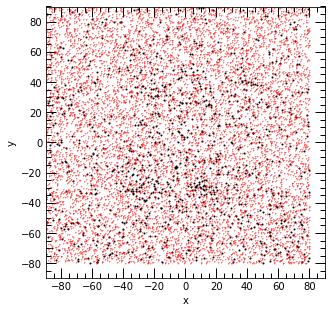

In [4]:
## import random galaxy positions previously generated and plot them
randData = gen_galaxy_positions()
if debug:
    randData = randData[::filt]
fig, ax = plot_data(dat=data);
ax.plot(randData[:,0],randData[:,1],'+',markersize=1,color='red',alpha=0.5);

In [5]:
## calculate distances to other points
def get_dist(mode='dd',pkl=False,save=False):
    start_time = time.time()
    if pkl and os.path.isfile(pkl):
        dist = pd.read_pickle(pkl)
        return dist
    elif mode == 'dd':
        d1 = data 
        d2 = data
    elif mode =='rr':
        d1 = randData
        d2 = randData
    elif mode == 'dr':
        d1 = data
        d2 = randData
    
    dist = np.linalg.norm(d2[:,None]-d1,axis=-1) ## calculates distances between all points in d1 and d2 (issue: double counts the distances if in dd or rr. Solved by only taking the upper triangle of the matrix)

    if mode == 'dd' or mode == 'rr': ## only take upper triangle of matrix to prevent double counting
        offset = 1 ## offset to remove self distances in dd and rr (i.e. distance between a point and itself)
        slice_idx = np.triu_indices_from(dist,k=offset) ## get indices for upper triangle of matrix
        #print(slice_idx)
        dist = dist[slice_idx] ## get upper triangle of matrix using indices
    elif mode == 'dr':
        dist = dist.flatten()
    if save:
        pd.to_pickle(dist, save)
    print("--- %s seconds ---" % (time.time() - start_time))
    return dist

In [6]:
## calculate distances
dd = get_dist('dd')
rr = get_dist('rr')
dr = get_dist('dr')

--- 0.03499794006347656 seconds ---
--- 3.070899724960327 seconds ---
--- 0.22730374336242676 seconds ---


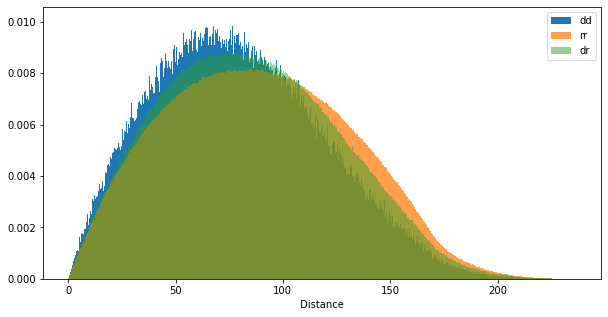

In [7]:
## plot histograms of distances
fig, ax = plt.figure(figsize=(10,5)), plt.gca()
plt.hist(dd,bins=1000,density=True,alpha=1,label='dd');
plt.hist(rr,bins=1000,density=True, alpha=0.75,label='rr');
plt.hist(dr,bins=1000,density=True, alpha=0.5,label='dr');
plt.legend();
plt.xlabel('Distance');

In [8]:
## develop correlation function
maxBin = 240
binWidth = 5
binArray = np.linspace(0,maxBin,int(maxBin/binWidth)+1) ## the bins to use for the correlation function
#print(binArray)
## calculate bin averages
def get_bin_averages(dataset,binWidth=binWidth,double=False,pkl=False,save=False):
    # startBin = binWidth*round(min(dataset)/binWidth)
    # endBin = binWidth*round(max(dataset)/binWidth)
    # bin = np.arange(startBin,endBin,binWidth)
    #print('Bin Array:',bin)
    start_time = time.time()
    bin = binArray
    if pkl and os.path.isfile(pkl):
        binAvgs = pd.read_pickle(pkl)
        return bin, binAvgs
    binAvgs, sp_bin, spc_binNum = binstat(dataset,dataset,statistic='mean',bins=bin)
    if double: ## accounts for the 2DR case
        binAvgs = binAvgs*2
    #binAvgs = binAvgs[:-1] ## remove last element of binAvgs (which is nan)
    #print(len(sp_bin), len(binAvgs))
    #idx = np.digitize(dataset,bin) ## get indices for each bin (digitize is a fast method to organize data into bins)
    #print(idx)
    #binAvgs = np.array([dataset[i].mean() for i in idx]); ## get the average of each bin
    if save:
        pd.to_pickle(binAvgs, save)
    print("--- %s seconds ---" % (time.time() - start_time))
    return bin[:-1], binAvgs ## remove the max bin value (because binstat returns the bin edges with other handedness)


In [9]:
dd_bin, dd_avg = get_bin_averages(dd)
rr_bin, rr_avg = get_bin_averages(rr)
dr_bin, dr_avg = get_bin_averages(dr)
two_dr_bin, two_dr_avg = get_bin_averages(dr, double=True)

--- 0.019780397415161133 seconds ---
--- 1.75648832321167 seconds ---
--- 0.33966708183288574 seconds ---
--- 0.34142351150512695 seconds ---


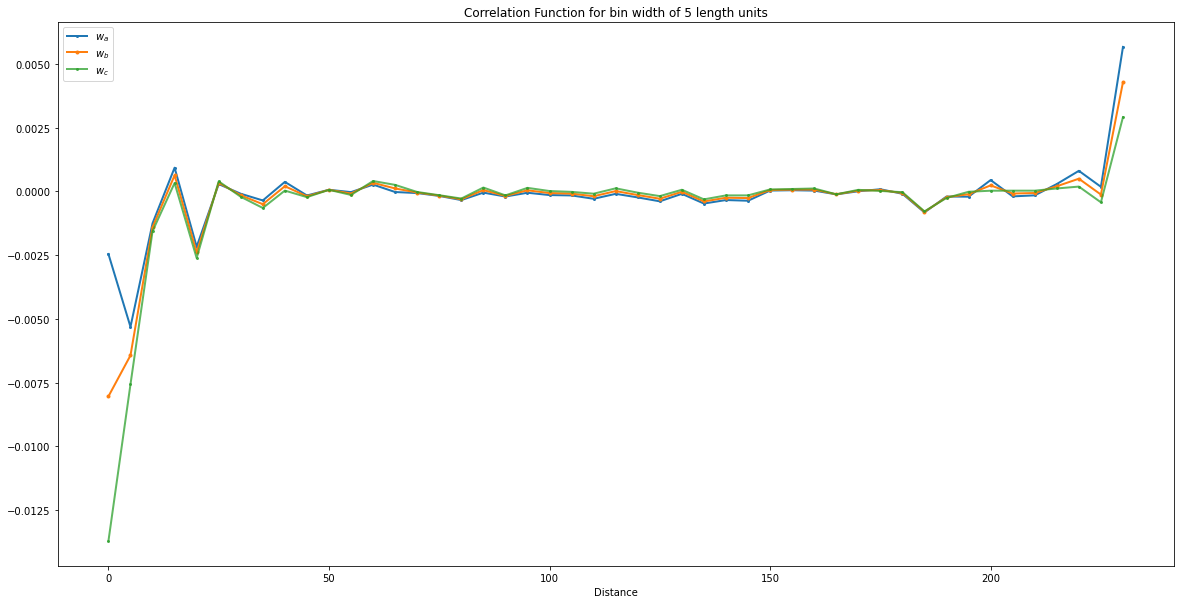

In [10]:
## calculate correlation function
w_a = [dd_i/rr_i -1 for dd_i,rr_i in zip(dd_avg,rr_avg)]
w_b = [dd_i/dr_i -1 for dd_i,dr_i in zip(dd_avg,dr_avg)]
w_c = [(dd_i - two_dr_i +rr_i)/(rr_i) for dd_i,two_dr_i,rr_i in zip(dd_avg,two_dr_avg,rr_avg)] ## w_c seems to be too big

## plot correlation function
fig, ax = plt.figure(figsize=(20,10)), plt.gca()
plt.plot(dd_bin,w_a,label=r'$w_a$',linestyle='-',linewidth=2, marker='o',markersize=2);
plt.plot(dr_bin,w_b,label=r'$w_b$',linestyle='-',linewidth=2, marker='o',markersize=3,alpha=1);
plt.plot(dr_bin,np.array(w_c),label=r'$w_c$',linestyle='-',linewidth=2, marker='o',markersize=2, alpha=0.75);
plt.legend();
plt.xlabel('Distance');
plt.title('Correlation Function for bin width of %s length units'%str(binWidth));

In [11]:
# print('dd: ',dd_avg, '\n \n rr: ', rr_avg,'\n \n dr: ',dr_avg,'\n \n 2dr: ',two_dr_avg)
# print()
# print('w_a: ',w_a,'\n \n w_b: ',w_b,'\n \n w_c: ',w_c)

In [12]:
print("--- %s seconds ---" % (time.time() - bigstart))

--- 13.134858846664429 seconds ---
